# Hyperparameters tuning via Random Search
In this notebook, we perform hyperparameter tuning of three models: Logistic Regression, K Nearest Neighbours and XGBoost using Random Search method.

## Table of contents
* [Libraries & packages](#lib)
* [Datasets](#data)
* [Preprocessing and models](#pr)
* [Crossvalidation with default hyperparameters](#def)
* [Random Search](#rs)
* [Bayes Search](#bs)


## **Libraries & packages** <a class="anchor" id="lib"></a>

In [ ]:
# %pip install scikit-learn
# %pip install pandas
# %pip install xgboost
# %pip install scikit-optimize

In [1]:
# data load
from sklearn.datasets import fetch_openml
# read data
import numpy as np
import pandas as pd
#stats
from scipy.stats import loguniform
# get subset of data
from sklearn.model_selection import train_test_split

In [2]:
# pipeline and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
# label encoding
from sklearn.preprocessing import LabelEncoder
# models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# cv
from sklearn.model_selection import cross_validate
# stats
from scipy.stats import uniform, expon, randint
# search 
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## **Data** <a class="anchor" id="data"></a>

In [4]:
def load_data(dataset, version=1):
    data = fetch_openml(name=dataset, as_frame=False, parser='liac-arff', version=version)
    X = pd.DataFrame(data.data)
    y = data.target
    return X, y

In [5]:
def split_and_transform(X, y):
    # we select random 5000 rows but we preserve the class distribution
    # from  dataset to meet our initial constraints 
    if X.shape[0] > 5000:
        X, _, y, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=0)
    X = pd.DataFrame(X)
    return X, y

Here we create global variable  
__DATASETS__=[('dataset_1_name', dataset_1_X, dataset_1_y), (dataset_2_name', dataset_2_X, dataset_2_y), ...].  

After loading data, the sets will ba added to the variable.

In [6]:
DATASETS = []

### 1. **Mushroom**

In [7]:
mushroom_X, mushroom_y = load_data('mushroom')
mushroom_X, mushroom_y = split_and_transform(mushroom_X, mushroom_y)
DATASETS.append(('mushroom', mushroom_X, mushroom_y))

### 2. **Ozone level**

In [8]:
ozone_X, ozone_y = load_data('ozone-level-8hr')
ozone_X, ozone_y = split_and_transform(ozone_X, ozone_y)
DATASETS.append(('ozone', ozone_X, ozone_y))

### 3. **kc1**

In [9]:
kc1_X, kc1_y = load_data('kc1')
kc1_X, kc1_y = split_and_transform(kc1_X, kc1_y)
DATASETS.append(('kc1', kc1_X, kc1_y))

### 4. **MagicTelescope**

In [10]:
magic_X, magic_y = load_data('MagicTelescope')
magic_X, magic_y = split_and_transform(magic_X, magic_y)
DATASETS.append(('magic', magic_X, magic_y))

### 5. **higgs**

In [11]:
higgs_X, higgs_y = load_data('higgs', version=2)
higgs_X, higgs_y = split_and_transform(higgs_X, higgs_y)
DATASETS.append(('higgs', higgs_X, higgs_y))

Finally, we encode all of the labels in y vector.

In [12]:
# Encode target variables in DATASETS
for i, (name, X, y) in enumerate(DATASETS):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    DATASETS[i] = (name, X, y_encoded)

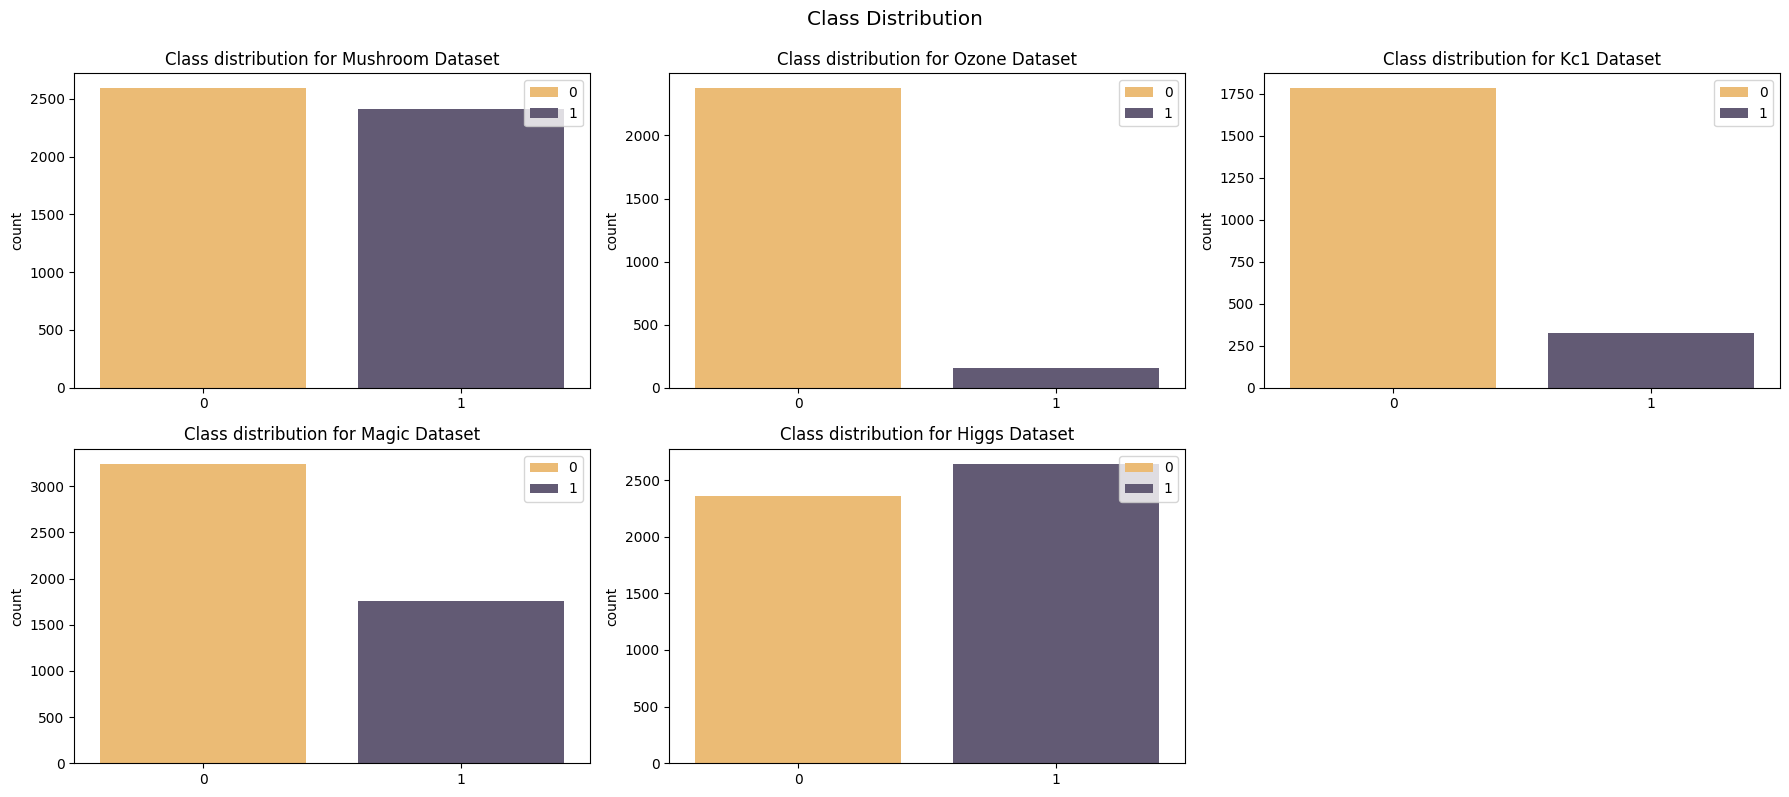

In [25]:
# distribution of classes on plot
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, (dataset_name, X, y) in enumerate(DATASETS):
    ax = axes[i]
    
    colors = ['#FFBF61', '#605678']
    sns.countplot(x=y, ax=ax, palette=colors, hue=y)
    ax.set_title(f'Class distribution for {dataset_name.capitalize()} Dataset')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f'Class Distribution', fontsize='x-large', y=0.99)
plt.tight_layout()
plt.savefig('../plots/class_distribution.png', transparent=True)
plt.show()


## **Preprocessing and models**  <a class="anchor" id="pr"></a>
In this paragraph, we create general pipeline for all possible cases and then use it for specific models.

In [13]:
# for NAs handling we impute median for numeric values and most frequent for categorical ones
num_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_transformer = ColumnTransformer(transformers=[
    ('num', num_pipe, make_column_selector(dtype_include=np.number)),
    ('non_num', cat_pipe, make_column_selector(dtype_include=np.object_))
], remainder='drop', n_jobs=-1)

Now we generate three pipelines with models.

In [14]:
xgb_pipe = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('xgb', XGBClassifier())
])

logreg_pipe = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('logreg', LogisticRegression())
])

knn_pipe = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('knn', KNeighborsClassifier())
])

Finally, we create global variable PIPES including all the pipelines and model names.  
__PIPES__ = [('xgb', xgb_pipe), ...]

In [15]:
PIPES = [('xgb', xgb_pipe), ('logreg', logreg_pipe), ('knn', knn_pipe)]

## **Crossvalidation with default hyperparameters**  <a class="anchor" id="def"></a>

In [16]:
def default_hyperparaeter_cv(DATASETS, PIPES):
    ''' 
    This function returns cross validation results on models with default hyperparameters and saves them to proper file.
    '''
    results = []
    for dataset_name, X, y in DATASETS:
        for pipe_name, pipe in PIPES:
            cv_results = cross_validate(pipe, X, y, cv=5, n_jobs=-1, return_train_score=True)
            cv_results['dataset'] = dataset_name
            cv_results['model'] = pipe_name
            results.append(cv_results)
    np.save('../results/default_hyperparameter.npy', results)


In [17]:
default_hyperparaeter_cv(DATASETS, PIPES)

## **Random Search**  <a class="anchor" id="rs"></a>
Here, we perform hyperparameter tuning on all datasets, using Random Search method.  

Firstly, let's define the hyperparameters grids.  

For Random Search purposes, we define **MODEL_PARAMS_R** grids.

In [18]:
XGB_PARAMS_RAND = {
    'xgb__n_estimators': randint(100, 1000), 
    'xgb__learning_rate': uniform(0.01, 1),
    'xgb__reg_alpha': loguniform(2**-10, 2**10),
    'xgb__reg_lambda': loguniform(2**-10, 2**10),
    'xgb__min_child_weight': randint(1, 100),
}

LOG_REG_PARAMS_RAND = {
    'logreg__C': loguniform(2**-10, 2**10),
    'logreg__max_iter': randint(7000, 8000), # to avoid ConvergenceWarning
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__fit_intercept': [True, False]
}

KNN_PARAMS_RAND = {
    'knn__n_neighbors': randint(1, 100),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

The function for running hyperparameter tuning on *all* datasets and *all* models.

In [19]:
def random_search_tuning(DATASETS, PIPES):
    ''' 
    This function performs RandomizedSearchCV search tuning on models and saves results to proper files.
    '''
    results = []
    for dataset_name, X, y in DATASETS:
        for pipe_name, pipe in PIPES:
            if pipe_name == 'xgb':
                search = RandomizedSearchCV(pipe, XGB_PARAMS_RAND, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=2137, error_score='raise')
            elif pipe_name == 'logreg':
                search = RandomizedSearchCV(pipe, LOG_REG_PARAMS_RAND, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=2137)
            elif pipe_name == 'knn':
                search = RandomizedSearchCV(pipe, KNN_PARAMS_RAND, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=2137, error_score='raise')
            search.fit(X, y)
            # save results and dataset_name and model_name
            search.cv_results_['dataset'] = dataset_name
            search.cv_results_['model'] = pipe_name
            results.append(search.cv_results_)
            print(f'Random search on dataset: {dataset_name}, model: {pipe_name}, status: done')
    np.save('../results/random_search_tuning.npy', results)
    print('Random search tuning done, results saved to file.')

In [20]:
# for testing & debugging purposes
# est. time 24 sec

# dataset_test = [('mushroom', DATASETS[0][1], DATASETS[0][2])]
# random_search_tuning(dataset_test, PIPES)

Our final calculations:

In [20]:
random_search_tuning(DATASETS, PIPES)

Random search on dataset: mushroom, model: xgb, status: done
Random search on dataset: mushroom, model: logreg, status: done
Random search on dataset: mushroom, model: knn, status: done
Random search on dataset: ozone, model: xgb, status: done
Random search on dataset: ozone, model: logreg, status: done
Random search on dataset: ozone, model: knn, status: done
Random search on dataset: kc1, model: xgb, status: done
Random search on dataset: kc1, model: logreg, status: done
Random search on dataset: kc1, model: knn, status: done
Random search on dataset: magic, model: xgb, status: done
Random search on dataset: magic, model: logreg, status: done
Random search on dataset: magic, model: knn, status: done
Random search on dataset: higgs, model: xgb, status: done
Random search on dataset: higgs, model: logreg, status: done
Random search on dataset: higgs, model: knn, status: done
Random search tuning done, results saved to file.


We present a sample element of our results file - the very last calculations results:  
- model: **KNN**,
- dataset: **higgs**.

In [21]:
results = np.load('../results/random_search_tuning.npy', allow_pickle=True)
pd.DataFrame(results[14]).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,dataset,model
0,0.014776,0.001022,0.039786,0.003467,euclidean,22,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.594,0.589,0.570,0.590,0.594,0.5874,0.008935,94,higgs,knn
1,0.016265,0.000851,0.043003,0.001974,euclidean,46,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.607,0.599,0.595,0.608,0.616,0.6050,0.007348,64,higgs,knn
2,0.016141,0.002096,0.035466,0.001399,euclidean,52,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.612,0.601,0.592,0.601,0.609,0.6030,0.007014,72,higgs,knn
3,0.019191,0.004771,0.080704,0.005264,manhattan,54,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.622,0.632,0.625,0.653,0.633,0.6330,0.010826,17,higgs,knn
4,0.016056,0.001005,0.031455,0.003526,minkowski,35,distance,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.605,0.599,0.581,0.609,0.594,0.5976,0.009749,79,higgs,knn


## **Bayes Search**  <a class="anchor" id="bs"></a>
Here, we perform hyperparameter tuning on all datasets, using Bayes Search method.  

In [23]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [22]:

XGB_PARAMS_BAYES = {
    'xgb__n_estimators': Integer(100, 1000, prior='uniform', transform='identity'),
    'xgb__learning_rate': Real(0.01, 1, prior='uniform', transform='identity'),
    'xgb__reg_alpha': Real(2**-10, 2*10, prior='log-uniform', transform='identity'),
    'xgb__reg_lambda': Real(2**-10, 2**10, prior='log-uniform', transform='identity'),
    'xgb__min_child_weight': Integer(1, 100, prior='uniform', transform='identity')
}

LOG_REG_PARAMS_BAYES = {
    'logreg__C': Real(2**-10, 2**10, prior='log-uniform', transform='identity'),
    'logreg__max_iter': Integer(7000, 8000, prior='uniform', transform='identity'),
    'logreg__penalty': Categorical(['l1', 'l2']),
    'logreg__solver': Categorical(['liblinear', 'saga']),
    'logreg__fit_intercept': Categorical([True, False])
}

KNN_PARAMS_BAYES = {
    'knn__n_neighbors': Integer(1, 100, prior='uniform', transform='identity'),
    'knn__weights': Categorical(['uniform', 'distance']),
    'knn__metric': Categorical(['euclidean', 'manhattan', 'minkowski'])
}

In [23]:
def bayes_optimization_tuning(DATASETS, PIPES):
    ''' 
    This function performs BayesSearchCV on models and saves results to proper files.
    '''
    results = []
    for dataset_name, X, y in DATASETS:
        for pipe_name, pipe in PIPES:
            if pipe_name == 'xgb':
                search = BayesSearchCV(pipe, XGB_PARAMS_BAYES, n_iter=60, cv=5, n_jobs=-1, scoring='roc_auc', random_state=2137, error_score='raise')
            elif pipe_name == 'logreg':
                search = BayesSearchCV(pipe, LOG_REG_PARAMS_BAYES, n_iter=60, cv=5, n_jobs=-1, scoring='roc_auc', random_state=2137, error_score='raise')
            elif pipe_name == 'knn':
                search = BayesSearchCV(pipe, KNN_PARAMS_BAYES, n_iter=60, cv=5, n_jobs=-1, scoring='roc_auc', random_state=2137, error_score='raise')
            search.fit(X, y)
            # save results and dataset_name and model_name
            search.cv_results_['dataset'] = dataset_name
            search.cv_results_['model'] = pipe_name
            results.append(search.cv_results_)
            print(f'Bayes search on dataset: {dataset_name}, model: {pipe_name}, status: done')
    np.save('../results/bayes_search_tuning.npy', results)
    print('Bayes optimization done, results saved to file.')

In [24]:
bayes_optimization_tuning(DATASETS, PIPES)

Bayes search on dataset: mushroom, model: xgb, status: done
Bayes search on dataset: mushroom, model: logreg, status: done
Bayes search on dataset: mushroom, model: knn, status: done
Bayes search on dataset: ozone, model: xgb, status: done
Bayes search on dataset: ozone, model: logreg, status: done
Bayes search on dataset: ozone, model: knn, status: done
Bayes search on dataset: kc1, model: xgb, status: done
Bayes search on dataset: kc1, model: logreg, status: done
Bayes search on dataset: kc1, model: knn, status: done
Bayes search on dataset: magic, model: xgb, status: done
Bayes search on dataset: magic, model: logreg, status: done
Bayes search on dataset: magic, model: knn, status: done
Bayes search on dataset: higgs, model: xgb, status: done
Bayes search on dataset: higgs, model: logreg, status: done
Bayes search on dataset: higgs, model: knn, status: done
Bayes optimization done, results saved to file.


Sample element of our results file - the very last calculations results:  
- model: **KNN**,
- dataset: **higgs**.

In [25]:
bayes_results = np.load('../results/bayes_search_tuning.npy', allow_pickle=True)
pd.DataFrame(bayes_results[14]).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,dataset,model
0,0.014823,0.000882,0.032256,0.000355,euclidean,55,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.653743,0.633415,0.618519,0.646851,0.659526,0.642411,0.014784,50,higgs,knn
1,0.014321,0.000735,0.069007,0.004207,manhattan,43,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.695584,0.671114,0.667730,0.691573,0.701400,0.685480,0.013521,19,higgs,knn
2,0.014231,0.000591,0.039709,0.001324,euclidean,82,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.657793,0.637890,0.636517,0.658738,0.668051,0.651798,0.012451,40,higgs,knn
3,0.014092,0.000734,0.029545,0.000272,euclidean,37,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.651120,0.628693,0.607965,0.647657,0.655106,0.638108,0.017588,51,higgs,knn
4,0.014138,0.000967,0.054536,0.002375,manhattan,7,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.654700,0.633959,0.618844,0.653826,0.628952,0.638056,0.014103,52,higgs,knn


---